In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import integrate
from scipy.interpolate import interp2d
from scipy.optimize import minimize

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Режимные параметры

In [3]:
G = 162419
print('Общий расход сырьевая смесь :', G)

Общий расход сырьевая смесь : 162419


In [4]:
Pc = 0.921*1e6
print('Давление на входе в теплообменник:', Pc)
Tc = 106
print('Температура на входе в теплообменник:', Tc)

Давление на входе в теплообменник: 921000.0
Температура на входе в теплообменник: 106


In [5]:
Poil = 1.3*1e6
print('Давление нефтепродуктов:', Poil)

Давление нефтепродуктов: 1300000.0


 Состав смеси газов

In [6]:
species= pd.read_csv('component_mass.csv', header=None, delimiter=r"\s+")
species.columns = ['species', 'Сырьевая смесь-вход', 'Сырьевая смесь-выход', 'Продуктовая смесь-вход', 'Продуктовая смесь-выход']
species

,species,Сырьевая смесь-вход,Сырьевая смесь-выход,Продуктовая смесь-вход,Продуктовая смесь-выход
0,Hydrogen,4.714217,4.714217,4.518113,4.518113
1,Hexane,0.110564,0.110564,0.105772,0.105772
2,n-Propane,2.738215,2.738215,2.619536,2.619536
3,Isobutane,0.760626,0.760626,0.727659,0.727659
4,Butane,0.551827,0.551827,2.091708,2.091708
5,I-Pentane,0.240676,0.240676,0.230245,0.230245
6,N-Pentane,0.092568,0.092568,0.088556,0.088556
7,Ethane,2.021565,2.021565,2.216928,2.216928
8,Nitrogen,0.014377,0.014377,0.013754,0.013754
9,Methane,1.107365,1.107365,1.074693,1.074693


Расход водородосодержащией смеси газов:

In [7]:
m4h2 = sum(species['Сырьевая смесь-вход'].iloc[:10])/100
print('Массовая доля водородосодержащией смеси:', m4h2)

Массовая доля водородосодержащией смеси: 0.12351999999999999


In [8]:
Gg = G*m4h2/3600
print('Расход газовой смеси кг/с:', Gg)

Расход газовой смеси кг/с: 5.572776355555555


In [9]:
Goil = G*(1-m4h2)/3600
print('Расход газовой нефтепродуктов кг/с:', Goil)

Расход газовой нефтепродуктов кг/с: 39.54361253333334


Состав ВСГ

In [10]:
H2MIXTURE = species[['species', 'Сырьевая смесь-вход']].iloc[:10]
H2MIXTURE

,species,Сырьевая смесь-вход
0,Hydrogen,4.714217
1,Hexane,0.110564
2,n-Propane,2.738215
3,Isobutane,0.760626
4,Butane,0.551827
5,I-Pentane,0.240676
6,N-Pentane,0.092568
7,Ethane,2.021565
8,Nitrogen,0.014377
9,Methane,1.107365


Молярные массы компонент ВСГ

In [11]:
H2MIXTURE['molar_mass'] = 0
H2MIXTURE['molar_mass'].loc[species['species']=='Hydrogen'] = 2.016
H2MIXTURE['molar_mass'].loc[species['species']=='Hexane'] = 86.172
H2MIXTURE['molar_mass'].loc[species['species']=='n-Propane'] = 44.094
H2MIXTURE['molar_mass'].loc[species['species']=='Isobutane'] = 58.12
H2MIXTURE['molar_mass'].loc[species['species']=='Butane'] = 58.12
H2MIXTURE['molar_mass'].loc[species['species']=='I-Pentane'] = 72.146
H2MIXTURE['molar_mass'].loc[species['species']=='N-Pentane'] = 72.146
H2MIXTURE['molar_mass'].loc[species['species']=='Ethane'] = 30.068
H2MIXTURE['molar_mass'].loc[species['species']=='Nitrogen'] = 28.016
H2MIXTURE['molar_mass'].loc[species['species']=='Methane'] = 16.042

Массовые доли ВСГ

In [12]:
H2MIXTURE['mass_fraction'] = H2MIXTURE['Сырьевая смесь-вход']/m4h2/100

Объемные доли ВСГ

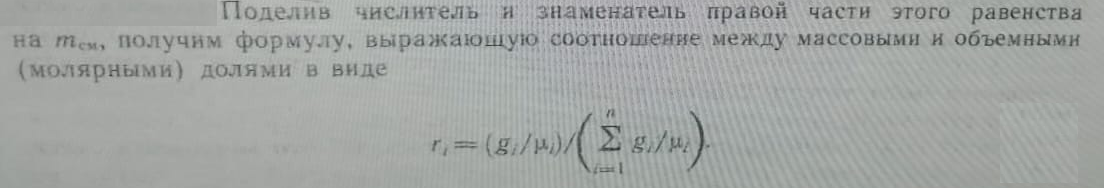

In [13]:
def gi2micalc (row):
    g2m = row['mass_fraction']/row['molar_mass']
    return g2m

In [14]:
H2MIXTURE['gi2mi'] = H2MIXTURE.apply(gi2micalc, axis =1)

In [15]:
H2MIXTURE['volume_fraction'] = H2MIXTURE['gi2mi']/ sum(H2MIXTURE['gi2mi'])
H2MIXTURE['vol2molarmass'] = H2MIXTURE['volume_fraction']*H2MIXTURE['molar_mass']

Критические температуры компонент ВСГ

In [16]:
H2MIXTURE['Tcrit'] = 0
H2MIXTURE['Tcrit'].loc[species['species']=='Hydrogen'] = 33.23
H2MIXTURE['Tcrit'].loc[species['species']=='Hexane'] = 234.7+273
H2MIXTURE['Tcrit'].loc[species['species']=='n-Propane'] = 96.84+273
H2MIXTURE['Tcrit'].loc[species['species']=='Isobutane'] = 134.98+273
H2MIXTURE['Tcrit'].loc[species['species']=='Butane'] = 152.01+273
H2MIXTURE['Tcrit'].loc[species['species']=='I-Pentane'] = 187.8+273
H2MIXTURE['Tcrit'].loc[species['species']=='N-Pentane'] = 196.62+273
H2MIXTURE['Tcrit'].loc[species['species']=='Ethane'] = 305.5
H2MIXTURE['Tcrit'].loc[species['species']=='Nitrogen'] = 126.25
H2MIXTURE['Tcrit'].loc[species['species']=='Methane'] = 190.55

In [17]:
H2MIXTURE['r*sqrt(MTcr)'] = H2MIXTURE['volume_fraction']*np.sqrt(H2MIXTURE['molar_mass']*H2MIXTURE['Tcrit'])
H2MIXTURE['r*(M)^1/3'] = H2MIXTURE['volume_fraction']*np.power(H2MIXTURE['molar_mass'], 1./3)
H2MIXTURE

,species,Сырьевая смесь-вход,molar_mass,mass_fraction,gi2mi,volume_fraction,vol2molarmass,Tcrit,r*sqrt(MTcr),r*(M)^1/3
0,Hydrogen,4.714217,2.016,0.381656,0.189314,0.911387,1.837357,33.23,7.459564,1.151330
1,Hexane,0.110564,86.172,0.008951,0.000104,0.000500,0.043092,507.70,0.104597,0.002209
2,n-Propane,2.738215,44.094,0.221682,0.005027,0.024203,1.067214,369.84,3.090784,0.085506
3,Isobutane,0.760626,58.120,0.061579,0.001060,0.005101,0.296453,407.98,0.785438,0.019758
4,Butane,0.551827,58.120,0.044675,0.000769,0.003701,0.215074,425.01,0.581599,0.014334
5,I-Pentane,0.240676,72.146,0.019485,0.000270,0.001300,0.093803,460.80,0.237065,0.005413
6,N-Pentane,0.092568,72.146,0.007494,0.000104,0.000500,0.036078,469.62,0.092048,0.002082
7,Ethane,2.021565,30.068,0.163663,0.005443,0.026204,0.787901,305.50,2.511453,0.081483
8,Nitrogen,0.014377,28.016,0.001164,0.000042,0.000200,0.005603,126.25,0.011895,0.000607
9,Methane,1.107365,16.042,0.089651,0.005588,0.026904,0.431593,190.55,1.487476,0.067853


**Индивидуальная газовая постоянная ВСГ**

In [18]:
Rsum = 8314*sum(H2MIXTURE['gi2mi'])
Rsum

1726.9858247596278

## Расчет теплового баланса на входе в теплообменник

Параметры нефтегазовой смеси в потоке газа (Pc = 0.921, Tc = 106)

Первая табличная точка (P = 1 MPa)

In [19]:
P1 = 1E6
Hl1 = -2026.04e3
Hg1 = -1449.71e3
m2vapour1 =0.258641513506995

Вторая табличная точка  (P = 0.9 MPa)

In [20]:
P2 = 0.9E6
Hl2 = -2045.93e3
Hg2 = -1478.46e3
m2vapour2 = 0.275344112170999

In [21]:
Hlc = np.interp(Pc, [P2, P1], [Hl2, Hl1])
print('Phase Enthalpy (Liquid Phase):', Hlc)

Phase Enthalpy (Liquid Phase): -2041753.1


In [22]:
Hgc = np.interp(Pc, [P2, P1], [Hg2, Hg1])
print('Phase Enthalpy (Vapour Phase):', Hgc)

Phase Enthalpy (Vapour Phase): -1472422.5


In [23]:
m2vapourc = np.interp(Pc, [P2, P1], [m2vapour2, m2vapour1])
print('Vap Frac on a Mass Basis:', m2vapourc)

Vap Frac on a Mass Basis: 0.2718365664515582


In [24]:
Htotc = Hgc*m2vapourc + Hlc*(1-m2vapourc)
print('Phase Mass Enthalpy (Overall):', Htotc)

Phase Mass Enthalpy (Overall): -1886988.2245201946


Изменение энтальпии нефтепродуктов (при охлаждении до Tc при Pc)

In [25]:
Htot_start = -1972.9216e3
print('Phase Mass Enthalpy (Overall) at T = 150 oC:', Htot_start)

Phase Mass Enthalpy (Overall) at T = 150 oC: -1972921.6


In [26]:
dHtot = Htotc - Htot_start
print('Изменение этнальпии нефтепродуктов при снижении температуры до 106 oC :', dHtot)

Изменение этнальпии нефтепродуктов при снижении температуры до 106 oC : 85933.37547980552


Количество теплоты подведенное к водородосодержащей смеси:

In [27]:
dQtot = dHtot*Goil
print('Подводимое к водородосодержащей смеси тепло, Дж/c:', dQtot)

Подводимое к водородосодержащей смеси тепло, Дж/c: 3398116.1036548773


Индивидуальные **теплоемкости** Cp газов водородосодержащей смеси газов (Н.Б. Варгафтик):

In [28]:
Ttab = [300, 350, 400]
Ptab = [0.8E6, 1E6]
Tgrid, Pgrid = np.meshgrid(Ttab, Ptab)

In [29]:
CpH2tab = np.array([[28.89, 28.90], [29.12, 29.13], [29.21, 29.21]])/0.00202
CpH2func = interp2d(Ptab, Ttab,CpH2tab, kind='linear')
CpH2 = CpH2func(Pc, Tc+273)
CpH2

array([14442.94108911])

In [30]:
CpHextab = np.array([[1670, 1670], [1891, 1891], [2112, 2112]])
CpHexfunc = interp2d(Ptab, Ttab,CpHextab, kind='linear')
CpHex = CpHexfunc(Pc, Tc+273)
CpHex

array([2019.18])

In [31]:
CpProtab = np.array([[2170, 2670], [2000, 2030], [2190, 2200]])
CpProfunc = interp2d(Ptab, Ttab,CpProtab, kind='linear')
CpPro = CpProfunc(Pc, Tc+273)
CpPro

array([2121.332])

In [32]:
CpIsobtab = np.array([[1675, 1675], [1910, 1910], [2145, 2145]])
CpIsobfunc = interp2d(Ptab, Ttab,CpIsobtab, kind='linear')
CpIsob = CpIsobfunc(Pc, Tc+273)
CpIsob

array([2046.3])

In [33]:
CpButtab = np.array([[1686, 1686], [1909, 1909], [2132, 2132]])
CpButfunc = interp2d(Ptab, Ttab,CpButtab, kind='linear')
CpBut = CpButfunc(Pc, Tc+273)
CpBut

array([2038.34])

In [34]:
CpIPentab = np.array([[1656, 1656], [1887, 1887], [2118, 2118]])
CpIPenfunc = interp2d(Ptab, Ttab,CpIPentab, kind='linear')
CpIPen = CpIPenfunc(Pc, Tc+273)
CpIPen

array([2020.98])

In [35]:
CpNPentab = np.array([[1675, 1675], [1897.5, 1897.5], [2120, 2120]])
CpNPenfunc = interp2d(Ptab, Ttab,CpNPentab, kind='linear')
CpNPen = CpNPenfunc(Pc, Tc+273)
CpNPen

array([2026.55])

In [36]:
CpEthtab = np.array([[1899, 1935], [2043, 2063], [2230, 2240]])
CpEthfunc = interp2d(Ptab, Ttab,CpEthtab, kind='linear')
CpEth = CpEthfunc(Pc, Tc+273)
CpEth

array([2160.051])

In [37]:
CpN2tab = np.array([[1052, 1055], [1050, 1052], [1051, 1052]])
CpN2func = interp2d(Ptab, Ttab,CpN2tab, kind='linear')
CpN2 = CpN2func(Pc, Tc+273)
CpN2

array([1051.4391])

In [38]:
CpMethtab = np.array([[2278, 2289], [2406, 2413.5], [2554, 2559]])
CpMethfunc = interp2d(Ptab, Ttab,CpMethtab, kind='linear')
CpMeth = CpMethfunc(Pc, Tc+273)
CpMeth

array([2495.50025])

Теплоемкость водородосодержащей смеси газов:

Теплоемкость определяем по объемным долям веществ ВСГ

In [39]:
def Cpfunc (Pc, Tc):
    mgas = H2MIXTURE['volume_fraction']
    Cpc =  (mgas[0]*CpH2func(Pc, Tc+273) +  mgas[1]*CpHexfunc(Pc, Tc+273) +  mgas[2]*CpProfunc(Pc, Tc+273) 
           +  mgas[3]*CpIsobfunc(Pc, Tc+273) +  mgas[4]*CpButfunc(Pc, Tc+273) +  mgas[5]*CpIPenfunc(Pc, Tc+273) 
           +  mgas[6]*CpNPenfunc(Pc, Tc+273) +  mgas[7]*CpEthfunc(Pc, Tc+273) +  mgas[8]*CpN2func(Pc, Tc+273) +  mgas[9]*CpMethfunc(Pc, Tc+273))
    return list(Cpc)[0]

Индивидуальные **вязкости** газов водородосодержащей смеси газов (Н.Б. Варгафтик):

In [40]:
Ttab = [300, 500]
Ptab = [0.1E6, 1E6]
Tgrid, Pgrid = np.meshgrid(Ttab, Ptab)

In [41]:
muH2tab = np.array([[896, 896], [1264, 1264]])*1e-8
muH2func = interp2d(Ptab, Ttab, muH2tab, kind='linear')
muH2 = muH2func(Pc, Tc+273)
muH2

array([1.04136e-05])

In [42]:
muHextab = np.array([[126, 168.5], [126, 168.5]])*1e-7
muHexfunc = interp2d(Ptab, Ttab,muHextab, kind='linear')
muHex = muHexfunc(Pc, Tc+273)
muHex

array([1.64769444e-05])

In [43]:
muProtab = np.array([[896, 896], [1264, 1264]])*1e-8
muProfunc = interp2d(Ptab, Ttab,muProtab, kind='linear')
muPro = muProfunc(Pc, Tc+273)
muPro

array([1.04136e-05])

In [44]:
muIsobtab = np.array([[145, 145], [145, 145]])*1e-7
muIsobfunc = interp2d(Ptab, Ttab,muIsobtab, kind='linear')
muIsob = muIsobfunc(Pc, Tc+273)
muIsob

array([1.45e-05])

In [45]:
muButtab = np.array([[128.5, 128.5], [128.5, 128.5]])*1e-7
muButfunc = interp2d(Ptab, Ttab,muButtab, kind='linear')
muBut = muButfunc(Pc, Tc+273)
muBut

array([1.285e-05])

In [46]:
muIPentab = np.array([[129.1, 129.1], [129.1, 129.1]])*1e-7
muIPenfunc = interp2d(Ptab, Ttab,muIPentab, kind='linear')
muIPen = muIPenfunc(Pc, Tc+273)
muIPen

array([1.291e-05])

In [47]:
muNPentab = np.array([[125.6, 125.6], [125.6, 125.6]])*1e-7
muNPenfunc = interp2d(Ptab, Ttab,muNPentab, kind='linear')
muNPen = muNPenfunc(Pc, Tc+273)
muNPen

array([1.256e-05])

In [48]:
muEthtab = np.array([[1530, 1535], [1530, 1535]])*1e-8
muEthfunc = interp2d(Ptab, Ttab,muEthtab, kind='linear')
muEth = muEthfunc(Pc, Tc+273)
muEth

array([1.53456111e-05])

In [49]:
muN2tab = np.array([[178.2, 179.7], [257.7, 258.6]])*1e-7
muN2func = interp2d(Ptab, Ttab,muN2tab, kind='linear')
muN2 = muN2func(Pc, Tc+273)
muN2

array([2.10754637e-05])

In [50]:
muMethtab = np.array([[11.14, 11.23], [16.70, 16.76]])*1e-6
muMethfunc = interp2d(Ptab, Ttab,muMethtab, kind='linear')
muMeth = muMethfunc(Pc, Tc+273)
muMeth

array([1.34074902e-05])

Вязкость водородосодержащей смеси газов:

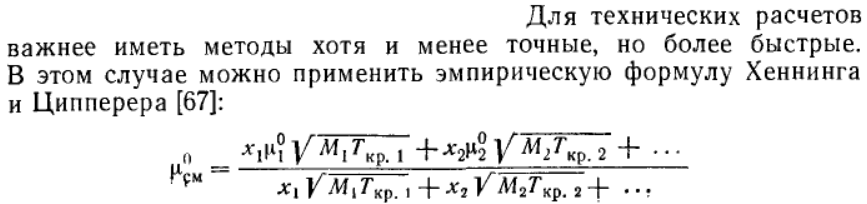

In [51]:
def mu_func (Pc, Tc):
    mgas = H2MIXTURE['r*sqrt(MTcr)']
    mu_c = (mgas[0]*muH2func(Pc, Tc+273) +  mgas[1]*muHexfunc(Pc, Tc+273) +  mgas[2]*muProfunc(Pc, Tc+273) +  mgas[3]*muIsobfunc(Pc, Tc+273) +  mgas[4]*muButfunc(Pc, Tc+273)
           +  mgas[5]*muIPenfunc(Pc, Tc+273) +  mgas[6]*muNPenfunc(Pc, Tc+273) +  mgas[7]*muEthfunc(Pc, Tc+273) +  mgas[8]*muN2func(Pc, Tc+273) +  mgas[9]*muMethfunc(Pc, Tc+273))
    mu_c = mu_c/sum(mgas)
    return list(mu_c)[0]

In [52]:
print('Вязкость ВСГ на входе в смесительную камеру:', mu_func(Pc, Tc))

Вязкость ВСГ на входе в смесительную камеру: 1.1820334948830999e-05


Индивидуальные **теплопроводности** газов водородосодержащей смеси газов (Н.Б. Варгафтик):

In [53]:
Ttab = [300, 400]
Ptab = [0.1E6, 1E6]
Tgrid, Pgrid = np.meshgrid(Ttab, Ptab)

In [54]:
lambH2tab = np.array([[183, 183], [226, 226]])*1e-3
lambH2func = interp2d(Ptab, Ttab, lambH2tab, kind='linear')
lambH2 = lambH2func(Pc, Tc+273)
lambH2

array([0.21697])

In [55]:
lambHextab = np.array([[46.1, 47.1], [60.7, 61.7]])*1e-3
lambHexfunc = interp2d(Ptab, Ttab,lambHextab, kind='linear')
lambHex = lambHexfunc(Pc, Tc+273)
lambHex

array([0.05854622])

In [56]:
lambProtab = np.array([[57.9, 57.9], [76, 76]])*1e-3
lambProfunc = interp2d(Ptab, Ttab, lambProtab, kind='linear')
lambPro = lambProfunc(Pc, Tc+273)
lambPro

array([0.072199])

In [57]:
lambIsobtab = np.array([[51.6, 51.6], [51.6, 51.6]])*1e-3
lambIsobfunc = interp2d(Ptab, Ttab,lambIsobtab, kind='linear')
lambIsob = lambIsobfunc(Pc, Tc+273)
lambIsob

array([0.0516])

In [58]:
lambButtab = np.array([[51.6, 51.6], [51.6, 51.6]])*1e-3
lambButfunc = interp2d(Ptab, Ttab,lambButtab, kind='linear')
lambBut = lambButfunc(Pc, Tc+273)
lambBut

array([0.0516])

In [59]:
lambIPentab = np.array([[0.0775, 0.0775], [0.0775, 0.0775]])
lambIPenfunc = interp2d(Ptab, Ttab,lambIPentab, kind='linear')
lambIPen = lambIPenfunc(Pc, Tc+273)
lambIPen

array([0.0775])

In [60]:
lambNPentab = np.array([[0.0876, 0.0876], [0.0876, 0.0876]])
lambNPenfunc = interp2d(Ptab, Ttab,lambNPentab, kind='linear')
lambNPen = lambNPenfunc(Pc, Tc+273)
lambNPen

array([0.0876])

In [61]:
lambEthtab = np.array([[65.9, 65.9], [65.9, 65.9]])*1e-3
lambEthfunc = interp2d(Ptab, Ttab,lambEthtab, kind='linear')
lambEth = lambEthfunc(Pc, Tc+273)
lambEth

array([0.0659])

In [62]:
lambN2tab = np.array([[43.32, 48.86], [43.32, 48.86]])*1e-3
lambN2func = interp2d(Ptab, Ttab,lambN2tab, kind='linear')
lambN2 = lambN2func(Pc, Tc+273)
lambN2

array([0.04837371])

In [63]:
lambMethtab = np.array([[80.1, 80.5], [80.1, 80.5]])*1e-3
lambMethfunc = interp2d(Ptab, Ttab,lambMethtab, kind='linear')
lambMeth = lambMethfunc(Pc, Tc+273)
lambMeth

array([0.08046489])

Теплопроводность водородосодержащей смеси газов:

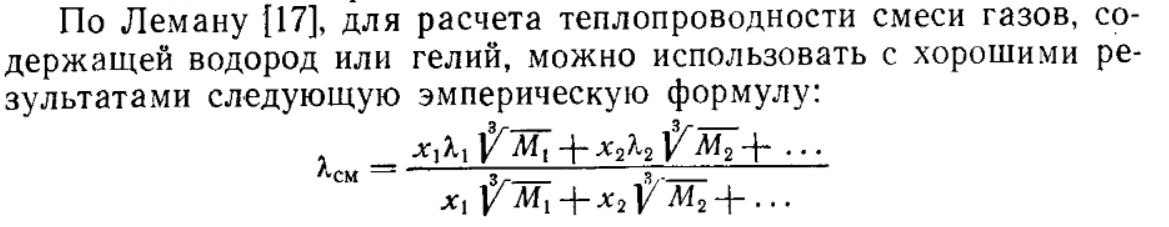

In [64]:
def lamb_func (Pc, Tc):
    mgas = H2MIXTURE['r*(M)^1/3']
    lamb_c = (mgas[0]*lambH2func(Pc, Tc+273) +  mgas[1]*lambHexfunc(Pc, Tc+273) +  mgas[2]*lambProfunc(Pc, Tc+273) 
            +  mgas[3]*lambIsobfunc(Pc, Tc+273) +  mgas[4]*lambButfunc(Pc, Tc+273)  +  mgas[5]*lambIPenfunc(Pc, Tc+273) 
            +  mgas[6]*lambNPenfunc(Pc, Tc+273) +  mgas[7]*lambEthfunc(Pc, Tc+273) +  mgas[8]*lambN2func(Pc, Tc+273) 
            +  mgas[9]*lambMethfunc(Pc, Tc+273))
    lamb_c = lamb_c/sum(mgas)
    return list(lamb_c)[0]

In [65]:
print('Теплопроводность ВСГ на входе в смесительную камеру:', lamb_func(Pc, Tc))

Теплопроводность ВСГ на входе в смесительную камеру: 0.18826466744020895


Определение количества тепла необходимого для изменения температуры водородосодержащей смеси газов:

In [66]:
def target_function_T(Tc):
    return Cpfunc(Pc, Tc)*Gg

Разница использованного тепла и подведенного от нефтесодержащей смеси в зависимости от начальной температуры водородосодержащей смеси:

In [67]:
def dQ (Titer):
    Qneed = integrate.quad(target_function_T, Titer+273, Tc+273)[0]
    return abs(Qneed - dQtot) 

In [68]:
res = minimize(dQ, 50, method='SLSQP')
Tstart = res.x[0]
print('Температура на входе:', Tstart)

Температура на входе: 60.43852242135498


## Свойства материалов

Данные из таблицы для свойств при P =1 МПа (t = 150 C)

In [69]:
visc = 0.00023
print('Вязкость нефтепродуктов', visc)
roil = 656.57
print('Плотность нефтепродуктов', roil)
sigma = 0.01267
print('Коэффициент поверхностного натяжения нефтепродуктов', sigma)

Вязкость нефтепродуктов 0.00023
Плотность нефтепродуктов 656.57
Коэффициент поверхностного натяжения нефтепродуктов 0.01267


In [70]:
rH2 = Pc/(60+273)/Rsum
print('Плотность ВСГ', rH2)
viscH2 = mu_func(Pc, Tc)
print('Вязкость ВСГ', viscH2)

Плотность ВСГ 1.6014988230437397
Вязкость ВСГ 1.1820334948830999e-05


## Геометрия и скорости потока

Геометрия канала для подвода нефтепродуктов (сечения)

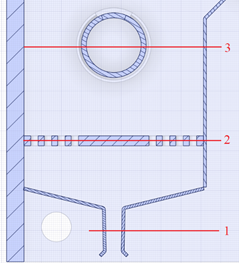

In [71]:
doil = 0.005          # диаметр отверстия
ioil = 98*2+97        # кол-во отверстий
Soil = (np.pi*doil**2)/4*ioil
print('Площадь проходного сечения суммарного', Soil)

Площадь проходного сечения суммарного 0.005753041546886308


In [72]:
S1gas = 1.5*0.03
print('Первое сечение канала подвода H2', S1gas)
dgas = 0.015                    # диаметр отверстия
igas = 55*8                     # кол-во отверстий
S2gas = (np.pi*dgas**2)/4*igas
print('Второе сечение канала подвода H2', S2gas)
S3gas = 1.5*(0.36-0.13)
print('Третье сечение канала подвода H2', S3gas)

Первое сечение канала подвода H2 0.045
Второе сечение канала подвода H2 0.07775441817634737
Третье сечение канала подвода H2 0.345


In [73]:
VFgas = Gg/rH2/2
VFoil = Goil/roil/2
print('Объемный расход H2', VFgas)
print('Объемный расход нефтепродуктов', VFoil)

Объемный расход H2 1.7398627696035942
Объемный расход нефтепродуктов 0.030113782638053317


In [74]:
Vel_gas1 = VFgas/S1gas/0.85
Vel_gas2 = VFgas/S2gas/0.85
Vel_gas3 = VFgas/S3gas/0.85
print ('Расходная скорость газа в сечении 1', Vel_gas1)
print ('Расходная скорость газа в сечении 2', Vel_gas2)
print ('Расходная скорость газа в сечении 3', Vel_gas3)

Расходная скорость газа в сечении 1 45.48660835564953
Расходная скорость газа в сечении 2 26.325158415588113
Расходная скорость газа в сечении 3 5.933035872476026


## Коэффициент расхода и среднерасходная скорость в канале

In [75]:
# Длина канала
lc = 0.01 
# Относительная длина канала (характерные значения 3<<6)
lrel=lc/doil
print('Относительная длина канала:', lrel)

Относительная длина канала: 2.0


**Число Рейнольдса**

In [76]:
Cd = 0.75        # сначала примем, потом пересчитаем

In [77]:
Vel_oil = VFoil/Soil/Cd

In [78]:
Re = Vel_oil*doil*roil/visc
print('Число Рейнольдса', Re)

Число Рейнольдса 99616.14724068856


According to Nakayama коэффициент расхода:

In [79]:
Cd = 0.868-0.0425*np.sqrt(lc/doil)
print('Коэффициент расхода по Nakayama', Cd)

Коэффициент расхода по Nakayama 0.8078959235991434


In [80]:
Vel_oil = VFoil/Soil/Cd
print ('Расходная скорость для нефтепродуктов', Vel_oil)

Расходная скорость для нефтепродуктов 6.4790657037985335


**Пересчет Числа Рейнольдса**

In [81]:
Re = Vel_oil*doil*roil/visc
print('Число Рейнольдса', Re)

Число Рейнольдса 92477.39498136964


**Потери давления на впрыске**

In [82]:
dP = roil*(Vel_oil**2)/2
print('Потери давления на впрыске Па,', dP)

Потери давления на впрыске Па, 13780.843718609722


**Давление в коллекторе**

In [83]:
Ptube = Pc + dP
print('Давление в коллекторе,', Ptube)

Давление в коллекторе, 934780.8437186098


## Распад капель

In [84]:
G1oil = Goil/ioil
print('Массовый расход нефтепродуктов, на один канал', G1oil)

Массовый расход нефтепродуктов, на один канал 0.13496113492605236


**Минимальная скорость истечения из канала для распады струи**

In [85]:
Ukr = np.sqrt(8*sigma/doil/roil) 
print('Критическая скорость истечения для распада струи', Ukr)

Критическая скорость истечения для распада струи 0.17571457290325274


**Число Вебера**

In [86]:
We_l = Vel_oil*Vel_oil*doil*roil/sigma
We_g = Vel_oil*Vel_oil*doil*rH2/sigma
print('Число Вебера по топливу', We_l)
print('Число Вебера по H2', We_g)

Число Вебера по топливу 10876.751159123694
Число Вебера по H2 26.530460087844748


**Число Онезорге**

In [87]:
Oh = visc/np.sqrt(roil*sigma*doil)
print('Число Онезорге', Oh)

Число Онезорге 0.0011277530462601908


**Режимы распада по критериальным числам**

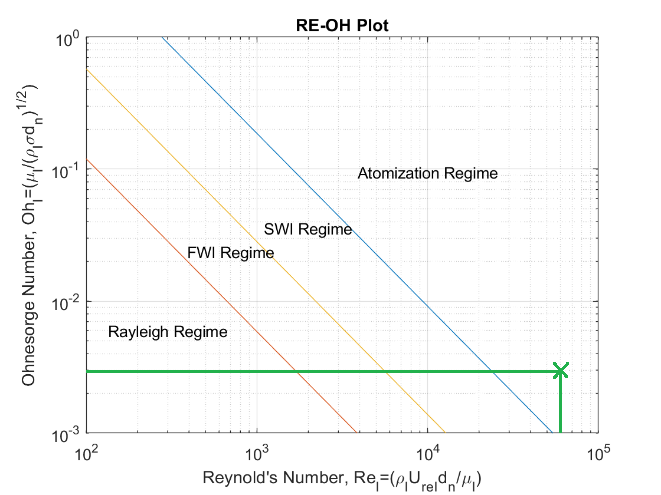

**Вывод:** Atomization

**Диаметр капли нефтепродуктов** (by Harmon [10]) - странная формула на нее битые ссылки и написано, что для разным режимов в разных книгах

In [88]:
ddrop = 330*pow(doil, 0.3)* pow(visc, 0.07)* pow(roil, -0.648)*pow(sigma, -0.15)*pow(Vel_oil, -0.55)*pow(viscH2, 0.78)*pow(rH2, -0.052)
print('Характерный диаметр капель', ddrop)

Характерный диаметр капель 5.3975331947483746e-05


**Диаметр капли нефтепродуктов** (Лышевский)

In [89]:
ddrop = 1.44*doil*pow(Oh, 0.1466)*pow(We_l*rH2/roil, -0.266)
print('Характерный диаметр капель', ddrop)

Характерный диаметр капель 0.001112937966917669


**Диаметр капли нефтепродуктов** (Tanasawa and Toyoda [13])

In [90]:
ddrop = 47*doil/Vel_oil*pow(sigma/rH2, 0.25)*(1+331*visc/np.sqrt(roil*sigma*doil))
print('Характерный диаметр капель', ddrop)

Характерный диаметр капель 0.014855218711761466


**Диаметр капли нефтепродуктов** (Elkotb [15]])

In [91]:
ddrop = 6156*pow(visc/roil, 0.385)*pow(sigma*roil, 0.737)*pow(rH2, 0.06)*pow(dP/101234, -0.54)/1e6
print('Характерный диаметр капель', ddrop)

Характерный диаметр капель 0.0002896890191730565


**Полученные в ANSYS в расчетной области**

In [92]:
ddrop_ansys = 9.082314e-04
print('Характерный диаметр капель полученный в ANSYS', ddrop_ansys)

Характерный диаметр капель полученный в ANSYS 0.0009082314


## Расчет критического диаметра капли с подхватом потока рабочего газа

Скорость потока газа:

In [103]:
S4gas = 0.36*1.5
Ugas = Gg/rH2/S4gas
Ugas

6.443936183717015

Начальная скорость капли:

In [104]:
Ud0 = Vel_oil
Ud0

6.4790657037985335

Решаем ОДУ относительно скорости капли:

$$\frac{dU}{dt} = -g -  \frac1 2  \frac{\rho A} m (Ugas-U)^2 Cd$$
$$Cd = \frac {24} {Re} + \frac 4 {\sqrt(Re)} + 0.4 $$


In [105]:
ddrop = doil         # критический случай диаметр капли равен диаметру отверстия 
ddrop = 1.3e-5

In [107]:
mdrop = np.pi*(ddrop**3)/4*roil
print('Масса капли', mdrop)
Adrop = np.pi*(ddrop**2)/4
print('Миделево сечение капли', Adrop)

Масса капли 1.132924512095672e-12
Миделево сечение капли 1.3273228961416874e-10


RHS:

In [109]:
def dudt(t, U):
    g = 9.81
    Red =  abs((Ugas - U)*ddrop*ro_tz/viscH2)
    Cd  = 24/Red + 4/np.sqrt(Red) + 0.4
    rhs = -g + 0.5*(ro_tz*Adrop)/mdrop*abs((Ugas - U)**3)/(Ugas - U)*Cd
    return rhs

Оценка времени прибывания капли в смесительной камере

In [110]:
Lchamb = 0.2*0.001  
print('Расстояние до входа в теплообменник, м: ', Lchamb)
t = np.linspace(0, 1.1*Lchamb/Ugas, 100)

Расстояние до входа в теплообменник, м:  0.0002


Решение уравнения:

In [111]:
Udrop = odeint(dudt, y0=Ud0, t=t, tfirst=True)

Скорость капли в потоке газа по времени:

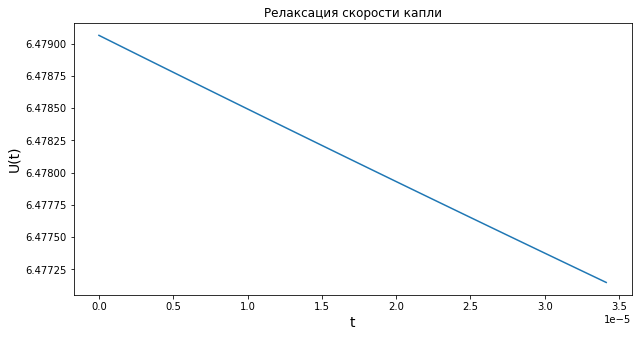

In [112]:
plt.figure(figsize=(10,5))
plt.title ('Релаксация скорости капли')
plt.plot(t, Udrop)
plt.ylabel('U(t)', fontsize=14)
plt.xlabel('t', fontsize=14)
plt.show()

Координата положения капли относительно форсунки:

In [113]:
Xdrop = integrate.cumtrapz(Udrop.T, t, initial=0)

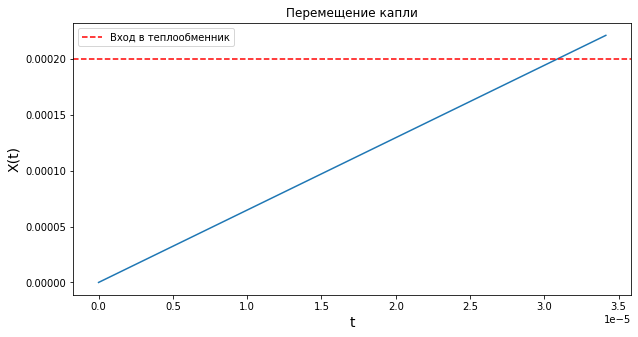

In [114]:
plt.figure(figsize=(10,5))
plt.title ('Перемещение капли')
plt.plot(t, Xdrop.T)
plt.axhline(y = Lchamb, color = 'r', linestyle='dashed', label = 'Вход в теплообменник')
plt.ylabel('X(t)', fontsize=14)
plt.xlabel('t', fontsize=14)
plt.legend()
plt.show()

**Выводы**
 - примерная среднерасходная скорость подачи нефтепродуктов составляет порядка 6.48 m/s;
 - среднерасходная скорость потока водорода составляется порядка 6.44 m/s;
 - параметры подачи нефтепродуктов, соответствуют режиму атомизации на капели струи, что является рациональным выбором;
 - значение средних Зауторовских диаметров капель, полученных по разным зависимостям достигают 1 мм, что несколько многовато. Стоит согласовать с возможных технологическим уровнем давления в магистрале нефтепродуктов ???;
 - начальной скорости нефтепродуктов и скорости потока газа достаточно, чтобы преодолеть действие силы тяжести и сопротивления среды и достичь поверхности теплообменного аппарата, для "предельного" случая диаметра капли равного диаметру подводящего отверстия;
 - до достижения поверхности теплообменного аппарата,  скорость капель остается выше скорости среды, влияние силы тяжести из за малости капель пренебрежимо мало   